<a href="https://colab.research.google.com/github/jese182/deeplearning_project/blob/main/GTZAN_music_classification/gtzan_vggish_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:57<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
# glob는 파일 경로를 검색하는 데 사용하는 Python 표준 라이브러리

import glob
audio_dir = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"

# 재귀적으로 모든 .wav 파일 탐색
audio_files = glob.glob(f"{audio_dir}/**/*.wav", recursive=True)
print(f"총 {len(audio_files)}개의 오디오 파일을 발견했습니다.")
# .wav 파일들의 파일 경로 리스트로 반환

총 1000개의 오디오 파일을 발견했습니다.


In [ ]:
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import soundfile as sf
import resampy

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
# 파일 경로에서 장르 추출 및 데이터프레임 생성
def extract_genre_from_path(path):
    parts = path.split(os.sep)
    for part in parts:
        if part in ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']:
            return part
    return None

# 문제가 있는 파일을 제외하고 데이터프레임 생성
data = pd.DataFrame({
    'path': audio_files,
    'genre': [extract_genre_from_path(path) for path in audio_files]
})

# jazz.00054.wav 파일 제외
data = data[~data['path'].str.contains('jazz.00054.wav')]

print("최종 데이터셋 크기:", len(data))
print("\n장르별 데이터 분포:")
print(data['genre'].value_counts())

최종 데이터셋 크기: 999

장르별 데이터 분포:
genre
blues        100
metal        100
classical    100
country      100
rock         100
hiphop       100
reggae       100
pop          100
disco        100
jazz          99
Name: count, dtype: int64


In [ ]:
data

,path,genre
0,/root/.cache/kagglehub/datasets/andradaolteanu...,rock
1,/root/.cache/kagglehub/datasets/andradaolteanu...,rock
2,/root/.cache/kagglehub/datasets/andradaolteanu...,rock
3,/root/.cache/kagglehub/datasets/andradaolteanu...,rock
4,/root/.cache/kagglehub/datasets/andradaolteanu...,rock
...,...,...
995,/root/.cache/kagglehub/datasets/andradaolteanu...,reggae
996,/root/.cache/kagglehub/datasets/andradaolteanu...,reggae
997,/root/.cache/kagglehub/datasets/andradaolteanu...,reggae
998,/root/.cache/kagglehub/datasets/andradaolteanu...,reggae


In [ ]:
# VGGish 모델 로드
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

# 오디오 파일 로드 및 전처리 함수
def load_and_process_audio(file_path):
    try:
        # 오디오 파일 로드
        audio, sr = sf.read(file_path)

        # 모노로 변환 (스테레오인 경우)
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)

        # 샘플링 레이트 변환 (VGGish는 16kHz 요구)
        if sr != 16000:
            audio = resampy.resample(audio, sr, 16000)

        # 정규화(필수는 아님)
        audio = audio / np.max(np.abs(audio))

        # VGGish 임베딩 추출 ([음원 파일] → [멜스펙트로그램 변환] → [CNN 처리] → [임베딩 추출])
        embedding = vggish_model(audio)

        return embedding

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# 테스트를 위해 하나의 파일로 시도
test_file = data['path'].iloc[0]
print("테스트 파일:", test_file)
test_embedding = load_and_process_audio(test_file)
if test_embedding is not None:
    print("임베딩 shape:", test_embedding.shape)

테스트 파일: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/blues/blues.00081.wav
임베딩 shape: (31, 128)


In [ ]:
# 테스트 파일의 기본 정보 확인
import librosa

# 테스트 파일 로드
audio, sr = librosa.load(test_file)

print("=== 테스트 파일 기본 정보 ===")
print(f"오디오 길이 (샘플 수): {len(audio)}")
print(f"오디오 길이 (초): {len(audio)/sr:.2f}초")
print(f"샘플링 레이트: {sr}Hz")
print(f"데이터 타입: {audio.dtype}")

# 첫 번째 임베딩 벡터 확인
print("\n=== VGGish 임베딩 상세 정보 ===")
print(f"임베딩 최소값: {test_embedding.numpy().min():.3f}")
print(f"임베딩 최대값: {test_embedding.numpy().max():.3f}")
print(f"임베딩 평균값: {test_embedding.numpy().mean():.3f}")

=== 테스트 파일 기본 정보 ===
오디오 길이 (샘플 수): 661794
오디오 길이 (초): 30.01초
샘플링 레이트: 22050Hz
데이터 타입: float32

=== VGGish 임베딩 상세 정보 ===
임베딩 최소값: -2.147
임베딩 최대값: 2.605
임베딩 평균값: -0.193


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 레이블 인코딩을 위한 함수
def prepare_sequences(data):
    print("데이터 준비 시작...")
    features = []
    labels = []

    # 레이블 인코더 생성
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(data['genre'])

    # 진행상황을 보기 위한 카운터
    total = len(data)

    for idx, (path, label) in enumerate(zip(data['path'], encoded_labels)):
        if idx % 100 == 0:  # 진행상황 출력
            print(f"처리 중: {idx}/{total} 파일")
        #vggish 임베딩적용
        embedding = load_and_process_audio(path)
        if embedding is not None:
            features.append(embedding.numpy())
            labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    print(f"\n최종 데이터 shape:")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")

    return features, labels, label_encoder

# 데이터 준비
X, y, label_encoder = prepare_sequences(data)

# 학습/검증/테스트 세트 분할 (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print("\n데이터 분할 결과:")
print(f"학습 데이터: {X_train.shape}")
print(f"검증 데이터: {X_val.shape}")
print(f"테스트 데이터: {X_test.shape}")

데이터 준비 시작...
처리 중: 0/999 파일
처리 중: 100/999 파일
처리 중: 200/999 파일
처리 중: 300/999 파일
처리 중: 400/999 파일
처리 중: 500/999 파일
처리 중: 600/999 파일
처리 중: 700/999 파일
처리 중: 800/999 파일
처리 중: 900/999 파일

최종 데이터 shape:
Features shape: (999, 31, 128)
Labels shape: (999,)

데이터 분할 결과:
학습 데이터: (599, 31, 128)
검증 데이터: (200, 31, 128)
테스트 데이터: (200, 31, 128)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalAveragePooling1D, BatchNormalization

def create_model():
    model = Sequential([
        # 단일 Conv1D 블록
        Conv1D(256, kernel_size=3, activation='relu', input_shape=(31, 128)),
        BatchNormalization(),
        Dropout(0.3),

        # 전역 평균 풀링
        GlobalAveragePooling1D(),

        # 분류를 위한 Dense 층
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')  # 10개 장르 분류
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 모델 생성
model = create_model()

# 모델 구조 출력
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 29, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 29, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 29, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,770 (522.54 KB)

 Trainable params: 133,258 (520.54 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 438ms/step - accuracy: 0.4753 - loss: 1.5860 - val_accuracy: 0.7050 - val_loss: 1.5762
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8069 - loss: 0.6517 - val_accuracy: 0.8100 - val_loss: 1.2861
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8361 - loss: 0.5127 - val_accuracy: 0.7850 - val_loss: 1.1915
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8609 - loss: 0.4454 - val_accuracy: 0.8300 - val_loss: 1.0659
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8685 - loss: 0.3797 - val_accuracy: 0.7950 - val_loss: 0.9663
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8764 - loss: 0.3387 - val_accuracy: 0.8050 - val_loss: 0.9180
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9036 - loss: 0.3256 - val_accuracy: 0.8400 - val_loss: 0.8098
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9157 - loss: 0.2618 - val_accuracy: 0.8350 

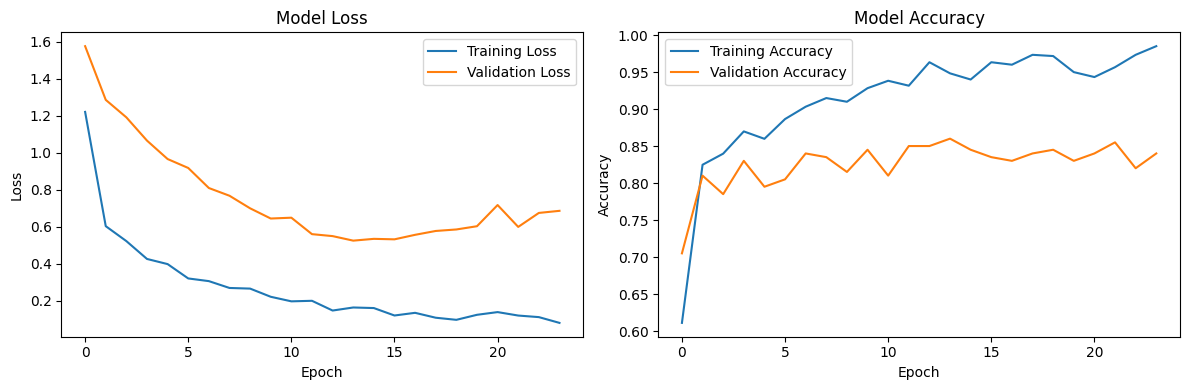

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',     # 검증 손실을 모니터링
    patience=10,            # 10 에폭동안 개선이 없으면 학습 중단
    restore_best_weights=True  # 가장 좋은 가중치 복원
)

# ModelCheckpoint 설정
model_checkpoint = ModelCheckpoint(
    'best_model.keras',        # 모델을 저장할 파일명
    monitor='val_loss',     # 검증 손실을 모니터링
    save_best_only=True,    # 가장 좋은 모델만 저장
    mode='min'              # 손실이 감소하는 방향으로
)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=100,             # 최대 에폭 수
    batch_size=32,          # 배치 크기
    validation_data=(X_val, y_val),  # 검증 데이터
    callbacks=[early_stopping, model_checkpoint],  # 콜백 함수들
    verbose=1              # 학습 진행 상황 출력
)

# 학습 결과를 시각화
plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 0.4162 

테스트 정확도: 0.8700
테스트 손실: 0.4446
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


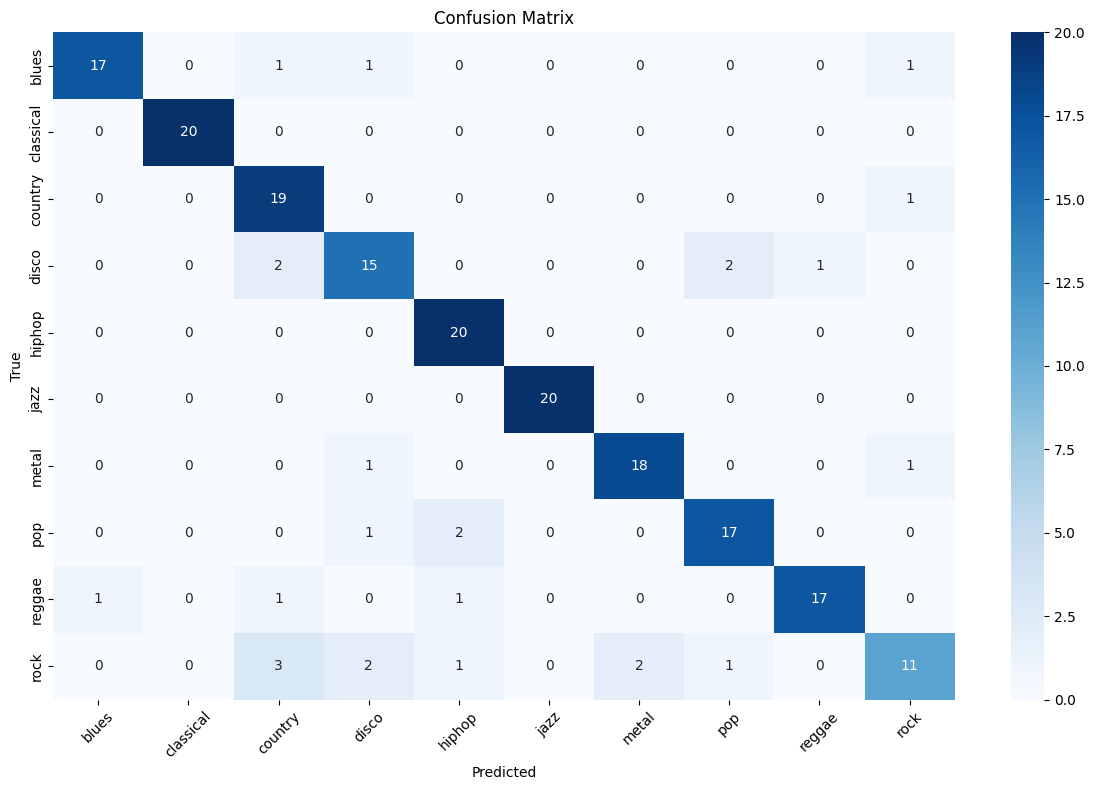


분류 리포트:
              precision    recall  f1-score   support

       blues       0.94      0.85      0.89        20
   classical       1.00      1.00      1.00        20
     country       0.73      0.95      0.83        20
       disco       0.75      0.75      0.75        20
      hiphop       0.83      1.00      0.91        20
        jazz       1.00      1.00      1.00        20
       metal       0.90      0.90      0.90        20
         pop       0.85      0.85      0.85        20
      reggae       0.94      0.85      0.89        20
        rock       0.79      0.55      0.65        20

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



In [ ]:
# 테스트 세트에 대한 예측 및 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n테스트 정확도: {test_accuracy:.4f}")
print(f"테스트 손실: {test_loss:.4f}")

# 혼동 행렬 생성을 위한 예측
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 예측값 생성
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred_classes)

# 장르 레이블 가져오기 (숫자 -> 텍스트 변환)
genre_labels = label_encoder.classes_

# 혼동 행렬 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_labels,
            yticklabels=genre_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 분류 리포트 출력
print("\n분류 리포트:")
print(classification_report(y_test, y_pred_classes, target_names=genre_labels))